In [1]:
import sys

import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import utils
from network import FourHeadedInception
from batch_generator import TwoMnistBatch
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4

In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

ExtractingExtractingExtractingExtracting   /tmp/t10k-labels-idx1-ubyte.gz /tmp/train-images-idx3-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz
/tmp/train-labels-idx1-ubyte.gz




In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images()
       .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]])
       .one_hot())

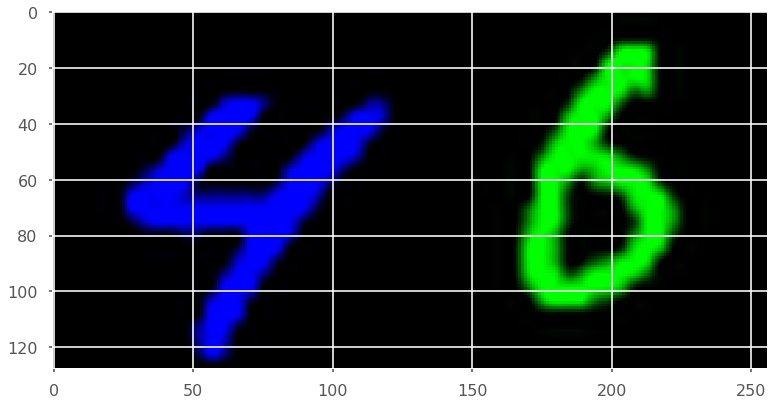

In [4]:
p = (ppl<<dset.train).next_batch(15)
plt.imshow(p.images[0].reshape(128, 256, 3))

In [5]:
inputs_config = {
    'images': {'shape':(128, 256, 3)},
    'col': {'shape':(2, 2),  'name':'color'},
    'num': {'shape':(2, 10), 'name':'number'}
}
                 
config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images',
          'head/color_importance': 1.}

four_headed_dict = {'images': B('images'),
                    'col': B('color'),
                    'num': B('number')}

In [6]:
four_train_ppl = ((ppl<<dset.train)
                    .init_model('dynamic',
                                FourHeadedInception,
                                'fourinception',
                                config=config)
                   .train_model('fourinception',
                                feed_dict=four_headed_dict))

four_test_ppl = ((ppl<<dset.test)
                   .import_model('fourinception', four_train_ppl)
                   .init_variable('loss_c', init_on_each_run=list)
                   .init_variable('loss_n', init_on_each_run=list)
                   .predict_model('fourinception',
                                 fetches=['FourHeadedInception/loss_c:0',
                                          'FourHeadedInception/loss_n:0'],
                                 feed_dict=four_headed_dict,
                                 save_to=[V('loss_c'),
                                          V('loss_n')],
                                 mode='a'))

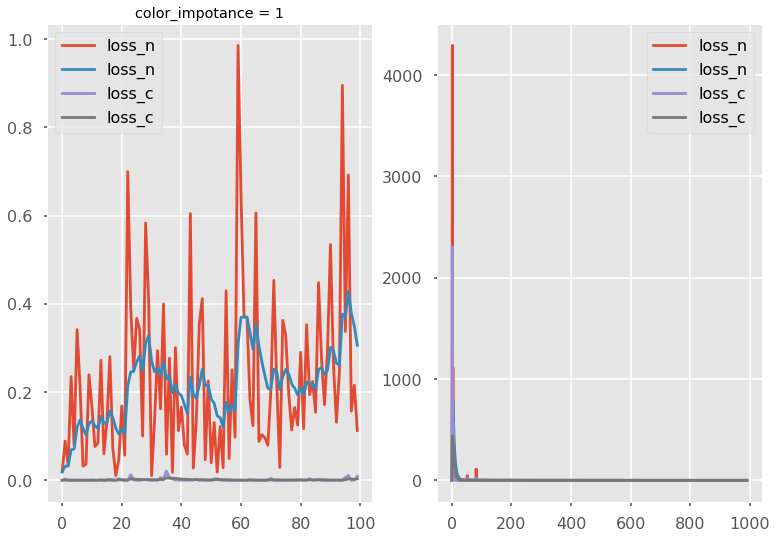

In [7]:
names = ['loss_n', 'loss_c']

for i in tqn(range(1000)):
    four_train_ppl.next_batch(24, n_epochs=None, shuffle=True)
    four_test_ppl.next_batch(24, n_epochs=None, shuffle=True)
    if i%10==0:
        clear_output(True)
        losses = np.array([four_test_ppl.get_variable(name) for name in names])
        utils.four_losses_draw(losses, names, 'color_impotance = 1')

In [8]:
four_headed_test = ((ppl<<dset.test)
                    .init_variable('color', init_on_each_run=list)
                    .init_variable('number', init_on_each_run=list)
                    .import_model('fourinception', four_train_ppl)
                    .predict_model('fourinception', 
                                   fetches=['FourHeadedInception/colors', 
                                            'FourHeadedInception/numbers'],
                                   feed_dict=four_headed_dict,
                                   save_to=[V('color'),
                                            V('number')], mode='a'))

In [9]:
colors_true = []
numbers_true = []
for i in tqn(range(300)):
    batch = four_headed_test.next_batch(100, n_epochs=None, suffle=True)

    numbers = four_headed_test.get_variable('number')
    colors = four_headed_test.get_variable('color')

    colors_true = batch.color if len(colors_true) == 0 else np.hstack((colors_true, batch.color))
    numbers_true = batch.number if len(numbers_true) == 0 else np.hstack((numbers_true, batch.number))
numbers = np.array(numbers).reshape(-1, 2, 10)
colors = np.array(colors).reshape(-1, 2, 2)
colors_true = colors_true.reshape(-1, 2, 2)
numbers_true = numbers_true.reshape(-1, 2, 10)

Accuracy on colors: 0.497 
Accuracy on numbers: 0.011


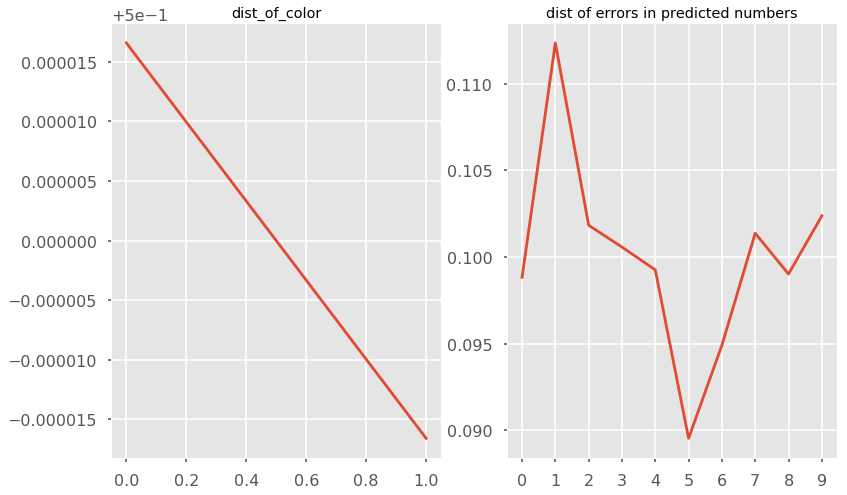

In [10]:
four_num_dist, acc_num,\
four_col_dist, acc_col = np.array(list(utils.class_accuracy([numbers, colors],\
                                                            [numbers_true, colors_true]))).reshape(-1)
print('Accuracy on colors: %.3f'%acc_col, '\nAccuracy on numbers: %.3f'%acc_num)

_, subplot = plt.subplots(1, 2, figsize=(13, 8))
subplot[0].set_title('dist_of_color')
if len(four_col_dist) == 0:
    print('No errors in color')
else:
    subplot[0].plot(four_col_dist)
subplot[1].set_title('dist of errors in predicted numbers')
plt.setp(subplot[1], xticks=range(11))
subplot[1].plot(four_num_dist)

In [11]:
ppl_inc = (Pipeline()
           .resize(shape=(128, 128))
           .normalize_images())

train_pp = ((ppl_inc<<dset.train)
                  .init_model('dynamic', Inception_v4, 'inception_v4',
                              config={'inputs': dict(images={'shape': (128, 128, 1)},
                                                   labels={'classes': 10, 
                                                           'transform': 'ohe', 
                                                           'name': 'targets'}),
                                    'input_block/inputs': 'images',
                                    'loss': 'softmax_cross_entropy',
                                    'optimizer': 'Adam',
                                    'output': dict(ops=['proba', 'accuracy'])})
                .resize(shape=(128, 128))
                .train_model('inception_v4',
                                     feed_dict={'images': B('images'),
                                                'labels': B('labels')}))

test_pp = ((ppl_inc<<dset.test)
                .import_model('inception_v4', train_pp)
                .resize(shape=(128, 128))
                .init_variable('loss', init_on_each_run=list)
                .predict_model('inception_v4', fetches='loss', feed_dict={'images': B('images'),
                                                                  'labels': B('labels')},
                               save_to=V('loss'), mode='a'))

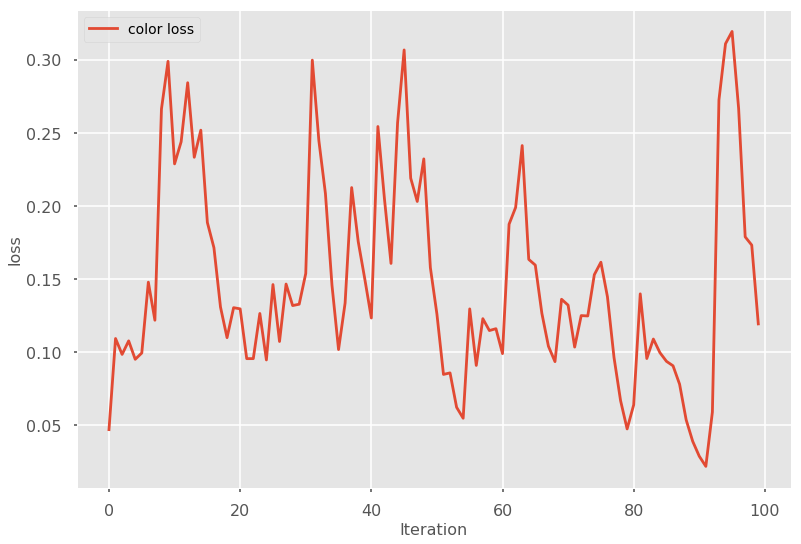

In [12]:
for i in tqn(range(1000)):
    train_pp.next_batch(24, n_epochs=None, shuffle=1)
    test_pp.next_batch(24, n_epochs=None, shuffle=1)
    if i%10==0:
        clear_output(True)
        losses = test_pp.get_variable('loss')
        utils.draw(losses[-100:], 'color')
        plt.show()

In [13]:
pred_ppl = ((ppl_inc<<dset.test)
           .resize(shape=(128, 128))
           .init_variable('predictions', init_on_each_run=list)
           .import_model('inception_v4', train_pp)
           .predict_model('inception_v4',
                          fetches='output_proba',
                          feed_dict={'images': B('images'),
                                     'labels': B('labels')},
                          save_to=V('predictions'), mode='a'))

real = []
for i in tqn(range(300)):
    batch = pred_ppl.next_batch(100, n_epochs=None, shuffle=2)
    predict = np.array(pred_ppl.get_variable('predictions'))
    real.append(np.array(batch.labels))
real = np.array(real).reshape(-1)
predict = predict.reshape(-1, 10)

accuracy: 0.00


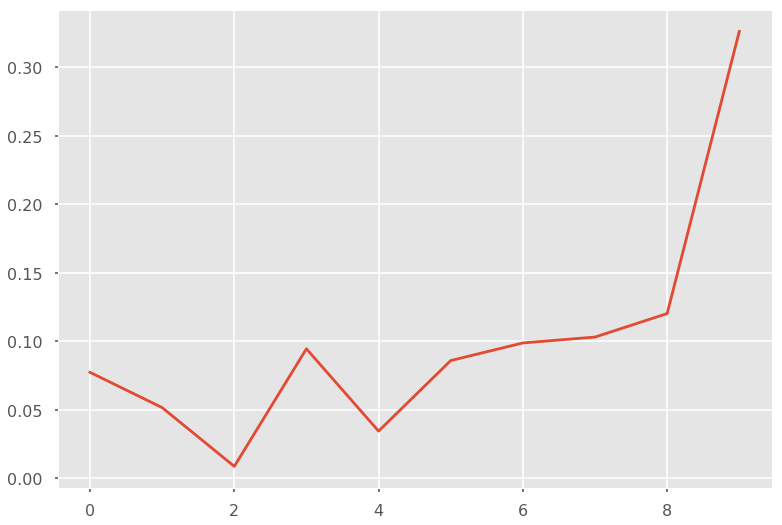

In [15]:
dist_inc, acc_inc = np.array(list(utils.class_accuracy([predict], [real]))[0])
print('accuracy: %.2f'%acc_inc)
plt.plot(dist_inc)

In [16]:
diff = np.abs(dist_inc - four_num_dist)

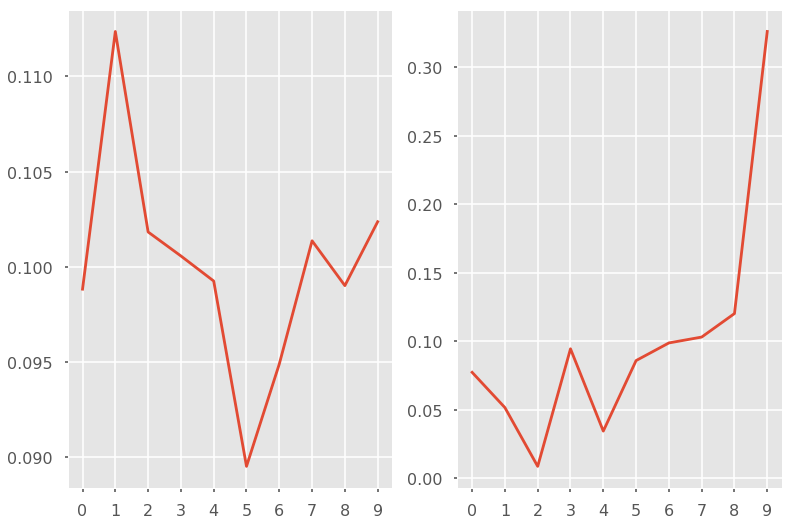

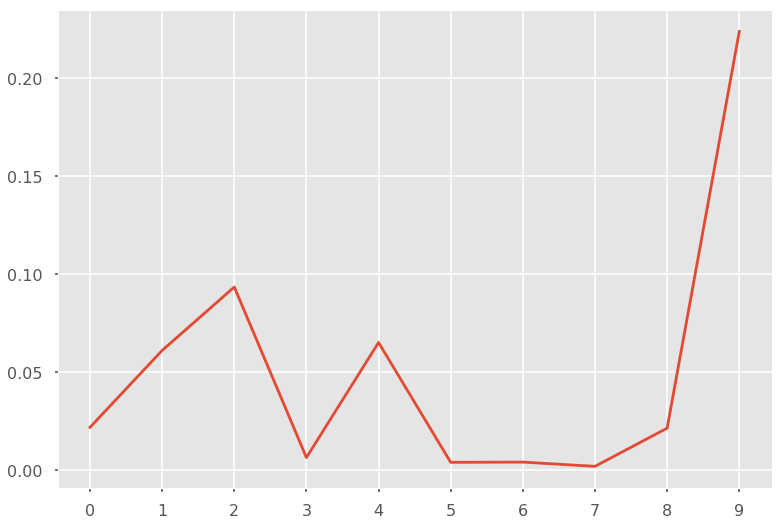

In [17]:
_, ax = plt.subplots(1, 2)
ax[0].plot(four_num_dist)
ax[1].plot(dist_inc)
plt.setp(ax[0], xticks=range(10))
plt.setp(ax[1], xticks=range(10))
plt.show()
plot = plt.plot(diff)
plt.xticks(range(10))
plt.show()